In [2]:
### LOAD THE KEYS FROM .env FILE

from dotenv import load_dotenv
load_dotenv() 

import os 
os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-Agent"


In [13]:
### Define Tavily search as a tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily = TavilySearchResults()


In [9]:
### Define Custom Functions 

# This will be a tool
def add(a:int,b:int) -> int:
    """Add a and b
    Args:
    a: first int
    b: second int
    """
    return a + b

def multiply(a:int,b:int) -> int:
    """Multiply a and b
    Args:
    a: first int
    b: second int
    """
    return a * b

def divide(a:int,b:int) -> float:
    """Divide a and b
    Args:
    a: first int
    b: second int
    """
    return a / b

In [11]:
### Define tools variable with all the functions (tavily,add,multiply,divide) created as tools for LLM
tools=[tavily,add,multiply,divide]

In [15]:
### Invoke
tavily.invoke("Provide me the recent AI news")


[{'title': 'The latest AI news we announced in December - Google Blog',
  'url': 'https://blog.google/technology/ai/google-ai-updates-december-2025/',
  'content': 'done. [...] # The latest AI news we announced in December\n\nDec 29, 2025\n\nHere’s a recap of our biggest AI updates from December, including the launch of Gemini 3 Flash, the release of new AI verification tools in the Gemini app and the arrival of Gemini’s powerful translation capabilities in Google Translate.\n\nSuperG [...] a text card reading "AI to help more people around the world"',
  'score': 0.994089},
 {'title': "Google's year in review: 8 areas with research breakthroughs in 2025",
  'url': 'https://blog.google/technology/ai/2025-research-breakthroughs/',
  'content': "In 2025, Google made significant AI research breakthroughs with models like Gemini 3 and Gemma 3. These advancements improved AI's reasoning, multimodality, and efficiency, leading to new products and features across Google's portfolio. Expect mo

In [ ]:
### Initialize my LLM model from Groq

from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")

### Binding the tools created above with my LLM and assign to a variable. Binding all these tools to this LLM.
llm_with_tools=llm.bind_tools(tools)

In [17]:
### Now, ask the queries and check which tool is responding to user query 
from pprint import pprint 
from langchain_core.messages import AIMessage,HumanMessage
llm_with_tools.invoke([HumanMessage(content=f"What is the latest AI news")])

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking for the latest AI news. I need to figure out which tool to use here. Let me check the available functions. There\'s tavily_search_results_json, which is a search engine optimized for current events. That sounds perfect for this query. The other functions are for math operations like add, multiply, and divide, which don\'t apply here. So I\'ll use the tavily_search_results_json function. The parameter required is a query, so I\'ll input "latest AI news" as the search term. I need to make sure the JSON is correctly formatted with the query parameter. Let me double-check the syntax to avoid any errors.\n', 'tool_calls': [{'id': '49dpz6hpn', 'function': {'arguments': '{"query":"latest AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 165, 'prompt_tokens': 423, 'total_tokens': 588, 'completion_time': 0.478538242, 'completion_

In [ ]:
# which tool my LLM is calling fro the above query. It must call "tavily"
llm_with_tools.invoke([HumanMessage(content=f"What is the latest AI news")]).tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news'},
  'id': 'gw6kcc1r9',
  'type': 'tool_call'}]

In [19]:
### So far, we difined the tools, LLM and bind the tools with LLM (Groq LLM)

In [21]:
### Now, we need to define the StateSchema for the graph

# Define the schema using TypedDict

from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated # Annotate lets you attach extra metadata like age: Annotated[int, "Age of the user"]. Python sees age as int, but framework can read the metadata
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

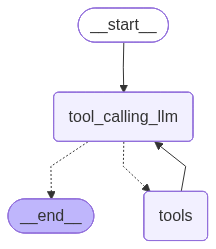

In [ ]:
### Now, create entire chatbot with LangGraph 

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

### Build the graph 
builder = StateGraph(State)

### Adding nodes 
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))       # for all the tools we defined (tavily,add,multiply,divide)

### Adding edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition (from langgraph.prebuilt import tools_condition) routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition (from langgraph.prebuilt import tools_condition) routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")  # before it was going to END, now we are calling tool_calling_llm node. See the graph.

# Compile the graph 
graph = builder.compile()

# View the graph 
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Now ask LLM the query. Now, LLM must call "tavily" search engine as a tool call and provide the results back to LLM.
# Next, LLM go with next sentence "add 5 plus 10" and LLM decide which tool to call. Here, "add" function and then tool pass the results back to LLM
# Next, LLM go with next sentence "then divide by 5" and LLM decide which tool to call.
# This tool calling process will continue in loop until final result handover to user.

messages=graph.invoke({"messages":HumanMessage(content="Provide me top 5 recent AI news from techcrunch.com, add 5 plus 10 then divide by 3")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me top 5 recent AI news from techcrunch.com, add 5 plus 10 then divide by 3
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (04rknb1gb)
 Call ID: 04rknb1gb
  Args:
    query: top 5 recent AI news TechCrunch
  add (3p48vgwqq)
 Call ID: 3p48vgwqq
  Args:
    a: 5
    b: 10
  divide (ss0q575qs)
 Call ID: ss0q575qs
  Args:
    a: 15
    b: 3
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "VCs predict strong enterprise AI adoption next year — again", "url": "https://techcrunch.com/2025/12/29/vcs-predict-strong-enterprise-ai-adoption-next-year-again/", "content": "© 2025 TechCrunch Media LLC. [...] ### Topics\n\nLatest\n\nAI\n\nAmazon\n\nApps\n\nBiotech & Health\n\nClimate\n\nCloud Computing\n\nCommerce\n\nCrypto\n\nEnterprise\n\nEVs\n\nFintech\n\nFundr

In [25]:
messages=graph.invoke({"messages":HumanMessage(content="Provide me top 5 recent AI news chatgpt.com, add 5 plus 5 then multiply by 10")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Provide me top 5 recent AI news chatgpt.com, add 5 plus 5 then multiply by 10
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (6k54c2dwh)
 Call ID: 6k54c2dwh
  Args:
    query: top 5 recent AI news chatgpt.com
  add (v2ht6he6e)
 Call ID: v2ht6he6e
  Args:
    a: 5
    b: 5
  multiply (mbp0s8f9r)
 Call ID: mbp0s8f9r
  Args:
    a: 10
    b: 10
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "It's been a big week for AI ; Here are 10 massive updates you might ...", "url": "https://www.reddit.com/r/artificial/comments/1pzlda5/its_been_a_big_week_for_ai_here_are_10_massive/", "content": "r/artificial icon\n\n# It's been a big week for AI ; Here are 10 massive updates you might've missed:\n\nNvidia acquires Groq in largest deal on record\n\nOpenAI hiring for cr

In [26]:
# Asking the basic question. Now, LLM must respond using training data trained with Natural language 
messages=graph.invoke({"messages":HumanMessage(content="Explain me about Data Science in 5 lines")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Explain me about Data Science in 5 lines
================================== Ai Message ==================================

Data Science is an interdisciplinary field that combines statistics, machine learning, and data analysis to extract insights from structured and unstructured data. It involves cleaning, processing, and modeling data to uncover patterns, predict outcomes, and inform decision-making. Tools like Python, R, SQL, and big data platforms (e.g., Hadoop) are commonly used. Applications span business, healthcare, finance, and technology to optimize processes and drive innovation. Data Science bridges the gap between raw data and actionable knowledge.


In [27]:
messages=graph.invoke({"messages":HumanMessage(content="Give me brief lines about Quantum Valley in India")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Give me brief lines about Quantum Valley in India
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (qx31tvta9)
 Call ID: qx31tvta9
  Args:
    query: Quantum Valley in India
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Andhra launches Quantum Valley, India Unveils 6G Mission ...", "url": "https://www.youtube.com/watch?v=ZfdWCSA9B9c", "content": "Andhra Pradesh has just announced Quantum Valley in Amaravati, a first-of-its-kind initiative to position India at the forefront of quantum computing and deep tech innovation. Global giants Microsoft (₹1,772 crore), IBM, and Fujitsu are partnering with the state to build high-performance quantum computers - including a 1,200-qubit system by Microsoft and a 133-qubit system by IBM. Spread over 50 acres and 90 lak

In [28]:
messages=graph.invoke({"messages":HumanMessage(content="What is 8 + 800?")})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 8 + 800?
================================== Ai Message ==================================
Tool Calls:
  add (dpw0tna24)
 Call ID: dpw0tna24
  Args:
    a: 8
    b: 800
================================= Tool Message =================================
Name: add

808
================================== Ai Message ==================================

The sum of 8 and 800 is **808**.


### Agent With Memory

In [34]:
# Run the same with different HumanMessage and see the result. Integrate Memory with specific agent usung "MemorySaver"


messages=graph.invoke({"messages":HumanMessage(content="Divide that with 8")})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Divide that with 8
================================== Ai Message ==================================

To perform the division, I need the number you'd like to divide by 8. Could you please provide the first number (the dividend)?


### MemorySaver
##### LangGraph can use a checkpointer to automatically save the graph state after each step. This is built-in persistence layer gives us memory, allowing LangGraph to pickup from the last state update. One of the easiest checkpointers to use is the MemorySaver, an in-memory key-value store for Graph state. All we need to do is simply compile the graph with a checkpointer, and our graph has memory.

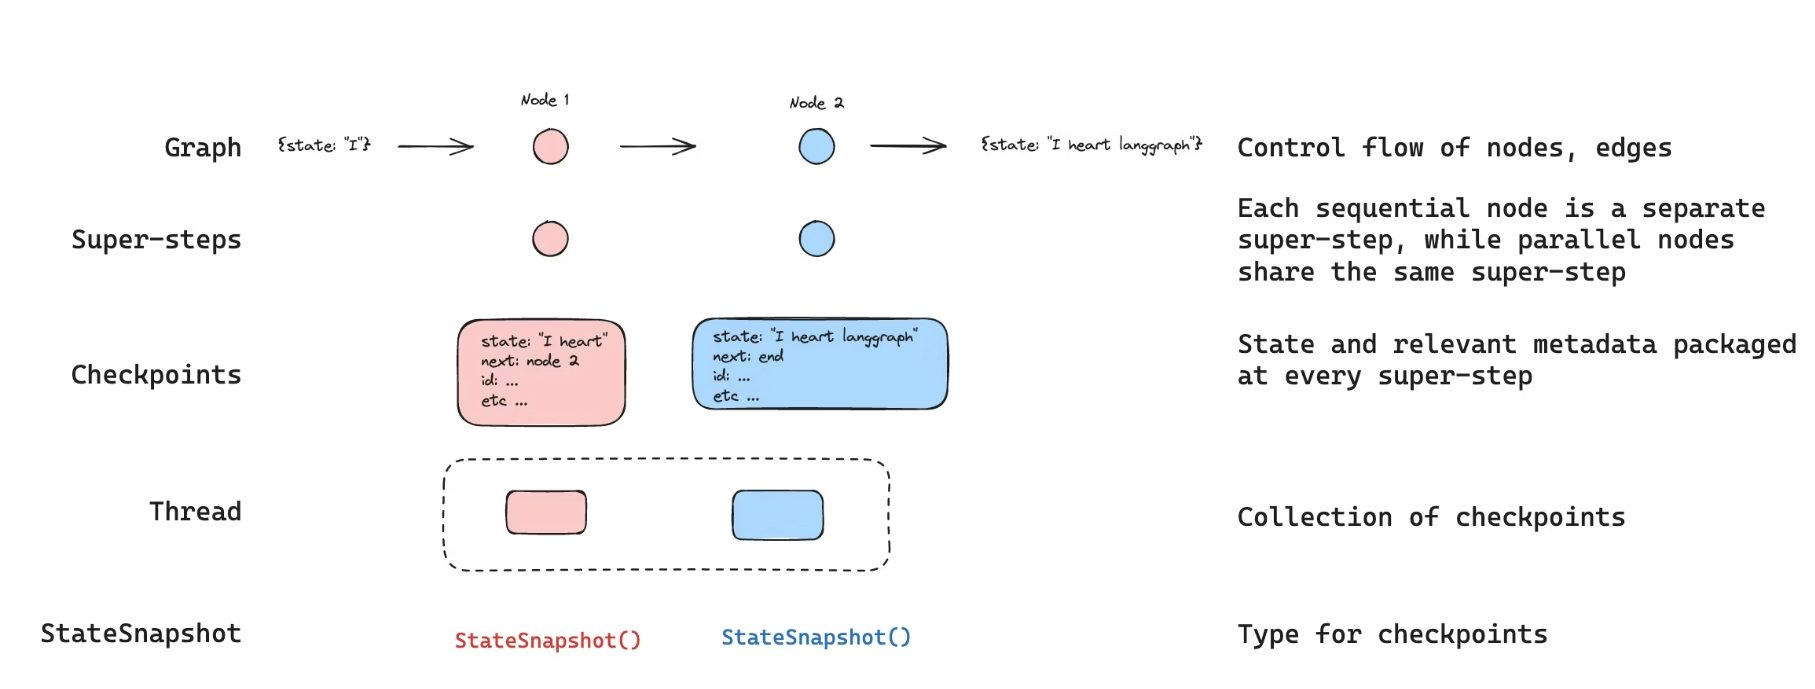
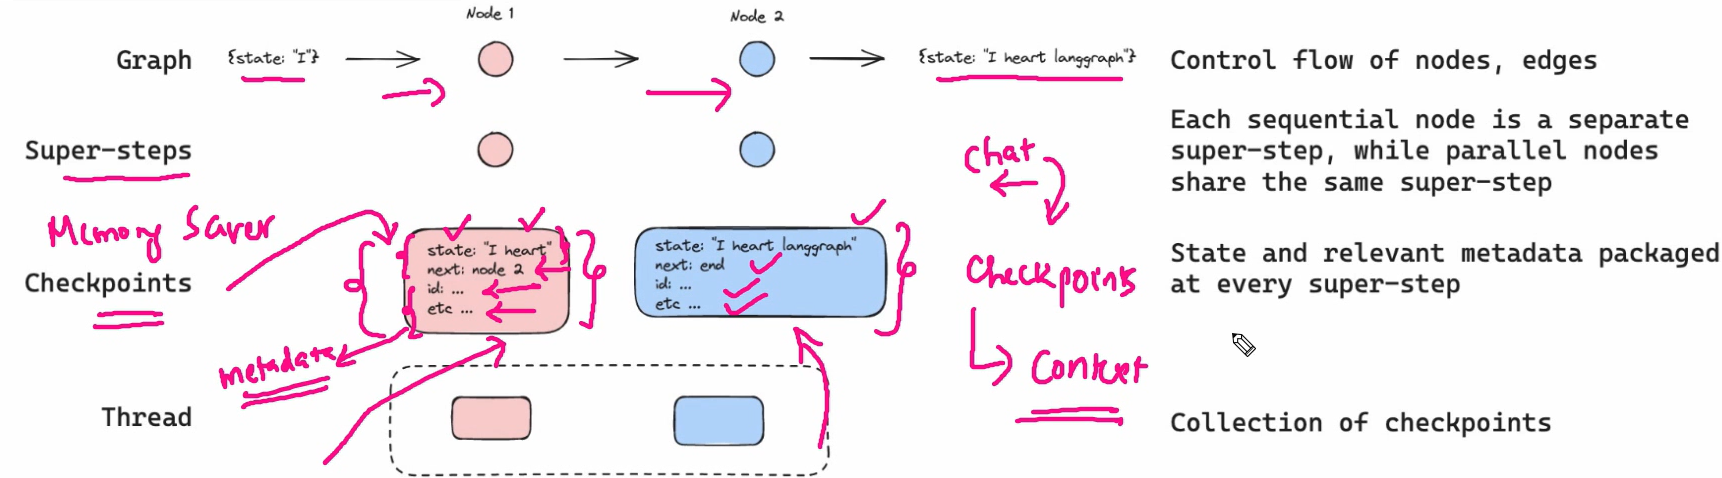

### So, how to implement MemorySaver?

In [58]:
### Create the graph again 
### Now, create entire chatbot with LangGraph 

# from langchain_openai import ChatOpenAI
# llm=ChatOpenAI(model="gpt-4o-mini")
# llm_with_tools=llm.bind_tools(tools)

from IPython.display import Image,display
from langgraph.graph import StateGraph,START,END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition 
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

### Build the graph 
builder = StateGraph(State)

### Adding nodes 
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))       # for all the tools we defined (tavily,add,multiply,divide)

### Adding edges 
builder.add_edge(START,"tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition (from langgraph.prebuilt import tools_condition) routes to tools
    # If the latest message (result) from assistant is not a tool call -> tools_condition (from langgraph.prebuilt import tools_condition) routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")  # before it was going to END, now we are calling tool_calling_llm node. See the graph.



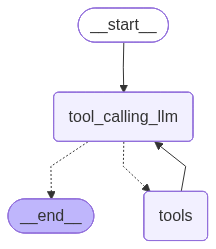

In [59]:
### Integrating the graph with MemorySaver
### after each node update, the check points updated in-memory.

from langgraph.checkpoint.memory import MemorySaver
memory=MemorySaver()
graph_with_memory = builder.compile(checkpointer=memory) # this memory is saving all the information in "in-memory"

# View the graph 
display(Image(graph_with_memory.get_graph().draw_mermaid_png()))

In [60]:
### How this will execute and how my graph able to remember the context? Using thread

# config thread
config={"configurable":{"thread_id":"1"}}  # this thread_id must be unique per documentation and this thread holds the collection of checkpointers

# Specify an input 
messages = [HumanMessage(content="Add 30 and 40")]

messages=graph_with_memory.invoke({"messages":messages},config=config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 30 and 40
================================== Ai Message ==================================
Tool Calls:
  add (call_YYE2NlCBFtlXJ2YaKD1kibWN)
 Call ID: call_YYE2NlCBFtlXJ2YaKD1kibWN
  Args:
    a: 30
    b: 40
================================= Tool Message =================================
Name: add

70
================================== Ai Message ==================================

The sum of 30 and 40 is 70.


In [61]:
### new query with extension of the privious results 

messages = [HumanMessage(content="Add that number to 30")]

messages=graph_with_memory.invoke({"messages":messages},config=config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 30 and 40
================================== Ai Message ==================================
Tool Calls:
  add (call_YYE2NlCBFtlXJ2YaKD1kibWN)
 Call ID: call_YYE2NlCBFtlXJ2YaKD1kibWN
  Args:
    a: 30
    b: 40
================================= Tool Message =================================
Name: add

70
================================== Ai Message ==================================

The sum of 30 and 40 is 70.
================================ Human Message =================================

Add that number to 30
================================== Ai Message ==================================
Tool Calls:
  add (call_DkcSDnMKEB8GMilYocZzwM2O)
 Call ID: call_DkcSDnMKEB8GMilYocZzwM2O
  Args:
    a: 70
    b: 30
================================= Tool Message =================================
Name: add

100
================================== Ai Message ==================================

Adding 70 and 30 gi

In [63]:
### new query with extension of the privious results 

messages = [HumanMessage(content="Divide that number with 25")]

messages=graph_with_memory.invoke({"messages":messages},config=config)
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

Add 30 and 40
================================== Ai Message ==================================
Tool Calls:
  add (call_YYE2NlCBFtlXJ2YaKD1kibWN)
 Call ID: call_YYE2NlCBFtlXJ2YaKD1kibWN
  Args:
    a: 30
    b: 40
================================= Tool Message =================================
Name: add

70
================================== Ai Message ==================================

The sum of 30 and 40 is 70.
================================ Human Message =================================

Add that number to 30
================================== Ai Message ==================================
Tool Calls:
  add (call_DkcSDnMKEB8GMilYocZzwM2O)
 Call ID: call_DkcSDnMKEB8GMilYocZzwM2O
  Args:
    a: 70
    b: 30
================================= Tool Message =================================
Name: add

100
================================== Ai Message ==================================

Adding 70 and 30 gi